In [105]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import hist.dask as dhist
import dask
import pickle
import os
import dask_awkward as dak

In [106]:
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")

In [107]:
files = os.listdir('/project01/ndcms/cmoore24/samples/hbb/')

hgg = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/samples/hbb/' + files[0]: "/Events"},
    #delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "hbb"},
).events()

In [108]:
genhiggs = hgg.GenPart[
    (hgg.GenPart.pdgId == 25)
    & hgg.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = hgg.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

cut = (
    (hgg.FatJet.pt > 200)
    & (hgg.FatJet.pt < 2500)
    & (hgg.FatJet.mass > 50)
    & (hgg.FatJet.mass < 200)
    & (abs(hgg.FatJet.eta) < 2.5)
    & (higgs_jets)  
)

In [109]:
hgg_fatjet = hgg.FatJet[cut]

In [110]:
pf = ak.flatten(hgg_fatjet.constituents.pf, axis=1)

In [111]:
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.8)

In [112]:
cluster = fastjet.ClusterSequence(pf, jetdef)

In [113]:
softdrop = cluster.exclusive_jets_softdrop_grooming()
softdrop_cluster = fastjet.ClusterSequence(softdrop.constituents, jetdef)

In [114]:
import matplotlib.pyplot as plt

In [115]:
cms_n2 = hgg_fatjet.n2b1.compute()
base_n2 = cluster.exclusive_jets_energy_correlator(func="N2").compute()
sd_n2 = softdrop_cluster.exclusive_jets_energy_correlator(func="N2").compute()

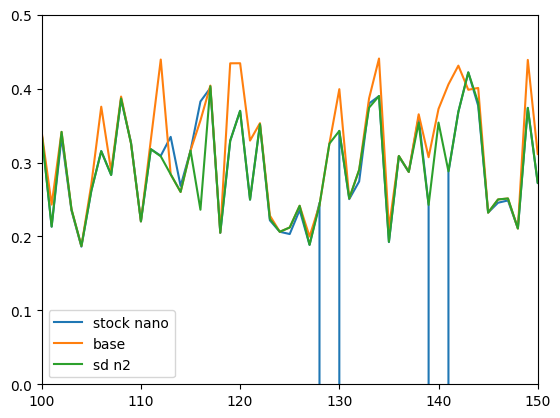

In [116]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_n2), label='stock nano')
ax.plot(base_n2, label='base')
ax.plot(sd_n2, label='sd n2')
ax.set_xlim(100,150)
ax.set_ylim(0,0.5)
plt.legend()
plt.show()

In [117]:
cms_msd = hgg_fatjet.msoftdrop.compute()
fj_msoftdrop = softdrop.msoftdrop.compute()

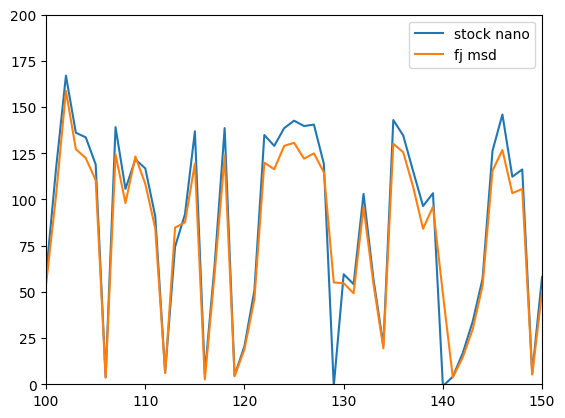

In [118]:
fig, ax = plt.subplots()
ax.plot(ak.flatten(cms_msd), label='stock nano')
ax.plot(fj_msoftdrop, label='fj msd')
ax.set_xlim(100,150)
ax.set_ylim(0,200)
plt.legend()
plt.show()

In [120]:
#hgg_exclusive = cluster.exclusive_jets(n_jets=3).compute()

In [ ]:
ak.all(ak.num(hgg_exclusive) == 3)

In [ ]:
cut = (
    (qcd.FatJet.pt > 200)
    & (qcd.FatJet.pt < 2500)
    & (qcd.FatJet.mass > 50)
    & (qcd.FatJet.mass < 200)
    & (abs(qcd.FatJet.eta) < 2.5) 
)

In [15]:
fatjet = qcd.FatJet[cut]

In [16]:
pf = ak.flatten(fatjet.constituents.pf, axis=1)

In [17]:
jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, 0.2)

In [18]:
cluster = fastjet.ClusterSequence(pf, jetdef)

In [19]:
qcd_exclusive = cluster.exclusive_jets(n_jets=3).compute()

In [20]:
ak.all(ak.num(qcd_exclusive) == 3)

True

In [21]:
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    subjets = cluster.exclusive_jets(n_jets=3)
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j, k = ak.unzip(ak.combinations(vec, 3))
    #best = ak.argmin(abs((i + j + k).mass - 125), axis=1, keepdims=True)
    best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)
    largest = ak.argmax(order_check, axis=1, keepdims=True)
    smallest = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)
    leg1 = leading_particles[largest]
    leg3 = leading_particles[smallest]
    leg2 = leading_particles[
        (leading_particles.idx != ak.flatten(leg1.idx))
        & (leading_particles.idx != ak.flatten(leg3.idx))
    ]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    leg3 = ak.firsts(leg3)
    a12 = np.arccos(leg1.dot(leg2) / (leg1.norm3 * leg2.norm3))
    a13 = np.arccos(leg1.dot(leg3) / (leg1.norm3 * leg3.norm3))
    a23 = np.arccos(leg2.dot(leg3) / (leg2.norm3 * leg3.norm3))
    color_ring = (a13**2 + a23**2) / (a12**2)
    return color_ring

In [22]:
uf_cr = ak.unflatten(
     color_ring(hgg_fatjet, cluster_val=0.2), counts=ak.num(hgg_fatjet)
).compute()

In [23]:
uf_cr

<Array [[2.28], [], [31.9], ..., [], [1.25], []] type='3000 * var * ?float64'>

In [24]:
subjets = qcd_exclusive

In [25]:
vec = ak.zip(
    {
        "x": subjets.px,
        "y": subjets.py,
        "z": subjets.pz,
        "t": subjets.E,
    },
    with_name="LorentzVector",
    behavior=vector.behavior,
)

In [26]:
vec = ak.pad_none(vec, 3)

In [27]:
vec["norm3"] = np.sqrt(vec.dot(vec))

In [28]:
vec["idx"] = ak.local_index(vec)

In [29]:
i, j, k = ak.unzip(ak.combinations(vec, 3))

In [30]:
best = ak.argmax(abs((i + j + k).mass), axis=1, keepdims=True)

In [31]:
order_check = ak.concatenate([i[best].mass, j[best].mass, k[best].mass], axis=1)

In [32]:
largest = ak.argmax(order_check, axis=1, keepdims=True)

In [33]:
smallest = ak.argmin(order_check, axis=1, keepdims=True)

In [34]:
leading_particles = ak.concatenate([i[best], j[best], k[best]], axis=1)

In [35]:
leg1 = leading_particles[largest]

In [36]:
leg3 = leading_particles[smallest]

In [37]:
leg2 = leading_particles[
    (leading_particles.idx != ak.flatten(leg1.idx))
    & (leading_particles.idx != ak.flatten(leg3.idx))
]

In [38]:
leg1 = ak.firsts(leg1)
leg2 = ak.firsts(leg2)
leg3 = ak.firsts(leg3)

In [39]:
a12 = leg1.delta_r2(leg2)

In [40]:
a13 = leg1.delta_r2(leg3)

In [41]:
a23 = leg2.delta_r2(leg3)

In [42]:
color_ring = (a13 + a23) / (a12)

In [46]:
leg1.eta

<Array [1.09, -0.491, -1.91, ..., -1.05, -1.98, -1.57] type='29369 * ?float64'>

In [73]:
i=4
leg1.pt[i]

2.8514720276930046

In [74]:
leg2.pt[i]

2.4940191514786236

In [75]:
leg3.pt[i]

3.584603171977805